In [1]:
!pip install transformers datasets torch torchvision pillow azure-ai-formrecognizer evaluate jiwer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 13.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of huggingface-hub to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 206.1 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 122.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.3/489.3 kB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import os
import json
import torch
from PIL import Image
import numpy as np
from pathlib import Path
import cv2
from typing import List, Dict, Tuple
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
from transformers import (
    TrOCRProcessor, 
    VisionEncoderDecoderModel,
    Seq2SeqTrainer, 
    Seq2SeqTrainingArguments,
    default_data_collator
)
from torch.utils.data import Dataset
import evaluate

# Azure imports
from azure.ai.formrecognizer import DocumentAnalysisClient
from azure.core.credentials import AzureKeyCredential

print("All libraries imported successfully!")

All libraries imported successfully!


In [ ]:
AZURE_ENDPOINT = os.getenv("AZURE_ENDPOINT")
AZURE_KEY = os.getenv("AZURE_KEY")


In [4]:
# INPUT_IMAGES_DIR = "input_images"
# OUTPUT_DIR = "trocr_training_data"
# MODEL_OUTPUT_DIR = "fine_tuned_trocr"

# os.makedirs(OUTPUT_DIR, exist_ok=True)
# os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

## Data Preparation

In [5]:
# Paths
INPUT_IMAGES_DIR = "input_images"
OUTPUT_DIR = "trocr_word_training_data"  
ANNOTATIONS_DIR = "word_annotations"
VISUALIZATIONS_DIR = "word_visualizations" 

for directory in [OUTPUT_DIR, ANNOTATIONS_DIR, VISUALIZATIONS_DIR]:
    os.makedirs(directory, exist_ok=True)

In [27]:
import time
class AzureWordExtractor:
    def __init__(self, endpoint: str, key: str):
        self.client = DocumentAnalysisClient(
            endpoint=endpoint,
            credential=AzureKeyCredential(key)
        )
    
    def extract_word_regions(self, image_path: str) -> List[Dict]:
        """Extract WORD regions and their content using Azure OCR"""
        
        with open(image_path, "rb") as f:
            poller = self.client.begin_analyze_document("prebuilt-read", document=f)
        result = poller.result()
        
        # Load image to get dimensions
        img = cv2.imread(image_path)
        img_height, img_width = img.shape[:2]
        
        word_regions = []
        
        for page_idx, page in enumerate(result.pages):
            # Extract WORDS instead of lines
            for word_idx, word in enumerate(page.words if hasattr(page, 'words') else []):
                if word.polygon and len(word.polygon) >= 4:
                    # Get bounding box coordinates
                    x_coords = [point.x for point in word.polygon]
                    y_coords = [point.y for point in word.polygon]
                    
                    x_min, x_max = int(min(x_coords)), int(max(x_coords))
                    y_min, y_max = int(min(y_coords)), int(max(y_coords))
                    
                    # Add padding
                    padding = 3  # Smaller padding for words
                    x_min = max(0, x_min - padding)
                    y_min = max(0, y_min - padding)
                    x_max = min(img_width, x_max + padding)
                    y_max = min(img_height, y_max + padding)
                    
                    # Filter out very small words or single characters
                    word_text = word.content.strip()
                    bbox_width = x_max - x_min
                    bbox_height = y_max - y_min
                    
                    # Skip very small or single character words
                    if len(word_text) >= 2 and bbox_width >= 10 and bbox_height >= 8:
                        word_regions.append({
                            'bbox': [x_min, y_min, x_max, y_max],
                            'text': word_text,
                            'confidence': getattr(word, 'confidence', 1.0),
                            'word_id': f"{Path(image_path).stem}_word_{word_idx}"
                        })
        
        return word_regions

azure_word_extractor = AzureWordExtractor(AZURE_ENDPOINT, AZURE_KEY)

def crop_word_regions(image_path: str, word_regions: List[Dict], output_dir: str) -> List[Dict]:
    """Crop WORD regions from image and save as individual images"""
    
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    cropped_word_data = []
    
    for region in word_regions:
        bbox = region['bbox']
        x_min, y_min, x_max, y_max = bbox
        
        # Additional filtering
        word_text = region['text'].strip()
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min
        
        # Crop the word region
        cropped_img = img_rgb[y_min:y_max, x_min:x_max]
        
        if cropped_img.size == 0:
            continue
        
        # Save cropped image
        crop_filename = f"{region['word_id']}.jpg"
        crop_path = os.path.join(output_dir, crop_filename)
        
        # Convert to PIL and save
        pil_img = Image.fromarray(cropped_img)
        pil_img.save(crop_path)
        
        cropped_word_data.append({
            'image_path': crop_path,
            'text': word_text,
            'confidence': region['confidence'],
            'original_image': image_path,
            'bbox': bbox
        })
    
    return cropped_word_data

# Cell 5: Process All Images for Words
print("Processing images and creating WORD region crops...")

all_word_data = []
image_files = list(Path(INPUT_IMAGES_DIR).glob("*.jpg")) + \
              list(Path(INPUT_IMAGES_DIR).glob("*.png")) + \
              list(Path(INPUT_IMAGES_DIR).glob("*.jpeg"))

word_crops_dir = os.path.join(OUTPUT_DIR, "cropped_word_regions")
os.makedirs(word_crops_dir, exist_ok=True)

for image_path in tqdm(image_files, desc="Processing images"):
    try:
        # Extract WORD regions using Azure OCR
        word_regions = azure_word_extractor.extract_word_regions(str(image_path))
        
        # Crop word regions
        word_data = crop_word_regions(str(image_path), word_regions, word_crops_dir)
        all_word_data.extend(word_data)
        
        print(f"Processed {image_path.name}: {len(word_data)} word regions")
        
        # Add delay to respect Azure rate limits
        time.sleep(1.0)
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

print(f"Total WORD regions extracted: {len(all_word_data)}")

Processing images and creating WORD region crops...


Processing images:   0%|          | 0/18 [00:00<?, ?it/s]

Processed img_10.png: 248 word regions


Processing images:   6%|▌         | 1/18 [00:06<01:58,  6.98s/it]

Processed img_1.png: 232 word regions


Processing images:  11%|█         | 2/18 [00:13<01:45,  6.59s/it]

Processed img_11.png: 12 word regions


Processing images:  17%|█▋        | 3/18 [00:16<01:18,  5.26s/it]

Processed img_13.png: 117 word regions


Processing images:  22%|██▏       | 4/18 [00:22<01:12,  5.18s/it]

Processed img_2.png: 310 word regions


Processing images:  28%|██▊       | 5/18 [00:29<01:17,  6.00s/it]

Processed img_3.png: 189 word regions


Processing images:  33%|███▎      | 6/18 [00:35<01:11,  5.93s/it]

Processed img_12.png: 210 word regions


Processing images:  39%|███▉      | 7/18 [00:41<01:06,  6.08s/it]

Processed img_16.png: 403 word regions


Processing images:  44%|████▍     | 8/18 [00:50<01:08,  6.89s/it]

Processed img_7.png: 453 word regions


Processing images:  50%|█████     | 9/18 [00:59<01:09,  7.68s/it]

Processed img_6.png: 301 word regions


Processing images:  56%|█████▌    | 10/18 [01:07<01:00,  7.62s/it]

Processed img_17.png: 303 word regions


Processing images:  61%|██████    | 11/18 [01:14<00:52,  7.54s/it]

Processed img_15.png: 168 word regions


Processing images:  67%|██████▋   | 12/18 [01:20<00:42,  7.07s/it]

Processed img_4.png: 152 word regions


Processing images:  72%|███████▏  | 13/18 [01:26<00:32,  6.59s/it]

Processed img_5.png: 237 word regions


Processing images:  78%|███████▊  | 14/18 [01:33<00:27,  6.86s/it]

Processed img_14.png: 158 word regions


Processing images:  83%|████████▎ | 15/18 [01:38<00:19,  6.34s/it]

Processed denial.png: 376 word regions


Processing images:  89%|████████▉ | 16/18 [01:46<00:13,  6.83s/it]

Processed img_8.png: 183 word regions


Processing images:  94%|█████████▍| 17/18 [01:52<00:06,  6.49s/it]

Processed img_9.png: 209 word regions


Processing images: 100%|██████████| 18/18 [01:58<00:00,  6.59s/it]

Total WORD regions extracted: 4261


📊 WORD Dataset Analysis:
Total word samples: 4261
Unique words: 2139
Average word length: 5.7 characters
Word length range: 2 - 31 characters
Average confidence: 0.987

Most common words:
  'of': 84 times
  'the': 70 times
  'and': 62 times
  'for': 48 times
  'to': 43 times
  'is': 36 times
  'sleep': 31 times
  'on': 29 times
  'with': 26 times
  'Sleep': 26 times

Word length distribution:
  2 chars: 569 words
  3 chars: 630 words
  4 chars: 564 words
  5 chars: 600 words
  6 chars: 425 words
  7 chars: 377 words
  8 chars: 344 words
  9 chars: 261 words
  10 chars: 226 words
  11 chars: 110 words
Visualizing sample word crops...


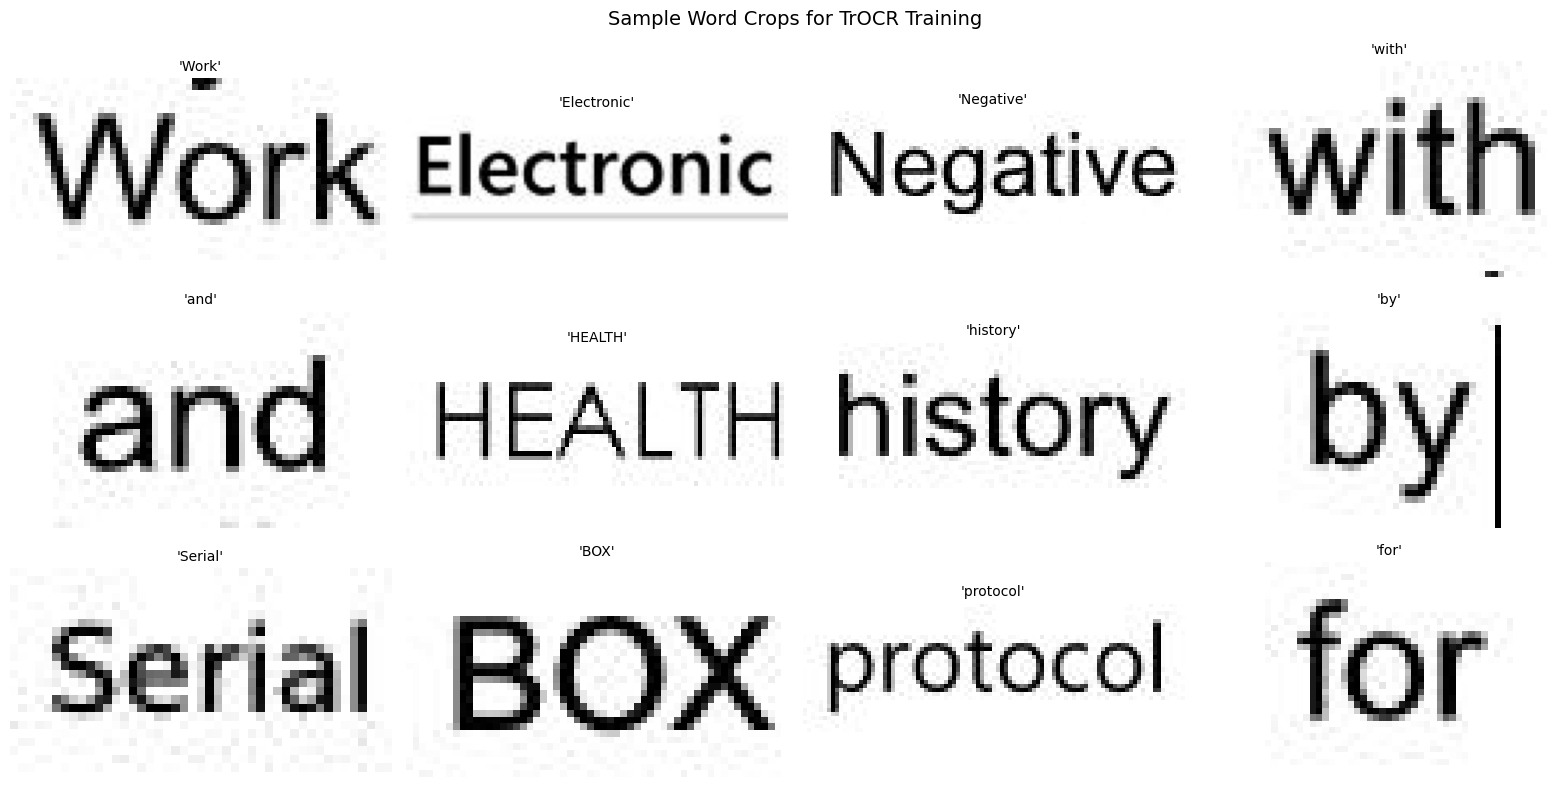

In [30]:
import pandas as pd
def analyze_word_dataset(word_data: List[Dict]) -> pd.DataFrame:
    """Analyze the word dataset"""
    
    stats_data = []
    
    # Overall statistics
    total_words = len(word_data)
    word_lengths = [len(item['text']) for item in word_data]
    confidences = [item['confidence'] for item in word_data]
    
    # Text statistics
    all_texts = [item['text'] for item in word_data]
    unique_words = len(set(all_texts))
    
    # Common words
    from collections import Counter
    word_counts = Counter(all_texts)
    most_common = word_counts.most_common(10)
    
    print("📊 WORD Dataset Analysis:")
    print(f"Total word samples: {total_words}")
    print(f"Unique words: {unique_words}")
    print(f"Average word length: {np.mean(word_lengths):.1f} characters")
    print(f"Word length range: {min(word_lengths)} - {max(word_lengths)} characters")
    print(f"Average confidence: {np.mean(confidences):.3f}")
    
    print(f"\nMost common words:")
    for word, count in most_common:
        print(f"  '{word}': {count} times")
    
    # Length distribution
    length_dist = Counter(word_lengths)
    print(f"\nWord length distribution:")
    for length in sorted(length_dist.keys())[:10]:
        print(f"  {length} chars: {length_dist[length]} words")
    
    return word_data

# Analyze the word dataset
analyzed_data = analyze_word_dataset(all_word_data)

# Cell 8: Visualize Word Samples
def visualize_word_samples(word_data: List[Dict], num_samples: int = 12):
    """Visualize sample word crops"""
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    # Sample random words
    import random
    sample_words = random.sample(word_data, min(num_samples, len(word_data)))
    
    for i, word_item in enumerate(sample_words):
        if i >= num_samples:
            break
            
        # Load and display image
        try:
            img = Image.open(word_item['image_path'])
            axes[i].imshow(img)
            axes[i].set_title(f"'{word_item['text']}'", fontsize=10)
            axes[i].axis('off')
        except:
            axes[i].text(0.5, 0.5, 'Error loading image', ha='center', va='center')
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(sample_words), num_samples):
        axes[i].axis('off')
    
    plt.suptitle("Sample Word Crops for TrOCR Training", fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualize samples
if all_word_data:
    print("Visualizing sample word crops...")
    visualize_word_samples(all_word_data)


In [33]:
word_dataset_info = {
    'total_samples': len(all_word_data),
    'samples': all_word_data,
    'extraction_type': 'words',  # Changed from 'lines'
}

with open(os.path.join(OUTPUT_DIR, 'word_dataset_info.json'), 'w') as f:
    json.dump(word_dataset_info, f, indent=2)

print(f"Word dataset info saved!")

Word dataset info saved!


In [8]:
import os
import json

file_path = os.path.join(OUTPUT_DIR, 'word_dataset_info.json')

with open(file_path, 'r') as f:
    saved_data = json.load(f)

all_word_data = saved_data["samples"]

In [9]:

# Cell 9: Create TrOCR Word Dataset Structure
def create_word_dataset_splits(word_data: List[Dict], output_dir: str):
    """Create train/val/test splits for word-level TrOCR training"""
    
    # Split data
    train_words, temp_words = train_test_split(word_data, test_size=0.3, random_state=42)
    val_words, test_words = train_test_split(temp_words, test_size=0.5, random_state=42)
    
    splits = {
        'train': train_words,
        'val': val_words,
        'test': test_words
    }
    
    print(f"Word dataset splits:")
    print(f"  Train: {len(train_words)} words")
    print(f"  Validation: {len(val_words)} words")
    print(f"  Test: {len(test_words)} words")
    
    # Save splits
    for split_name, split_data in splits.items():
        split_file = os.path.join(output_dir, f'{split_name}_words.json')
        with open(split_file, 'w') as f:
            json.dump(split_data, f, indent=2)
    
    return splits

# Create word dataset splits
word_splits = create_word_dataset_splits(all_word_data, OUTPUT_DIR)


Word dataset splits:
  Train: 2982 words
  Validation: 639 words
  Test: 640 words


## Fine-tuning the model

In [ ]:
class TrOCRDataset(Dataset):
    def __init__(self, data_list: List[Dict], processor, max_target_length: int = 128):
        self.data_list = data_list
        self.processor = processor
        self.max_target_length = max_target_length
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        item = self.data_list[idx]
        
        # Load and process image
        image = Image.open(item['image_path']).convert('RGB')
        
        # Process image
        pixel_values = self.processor(image, return_tensors="pt").pixel_values.squeeze()
        
        # Process text (labels)
        text = item['text']
        labels = self.processor.tokenizer(
            text,
            padding="max_length",
            max_length=self.max_target_length,
            truncation=True,
            return_tensors="pt"
        ).input_ids.squeeze()
        
        # Replace pad tokens with -100 (ignored in loss calculation)
        labels[labels == self.processor.tokenizer.pad_token_id] = -100
        
        return {
            "pixel_values": pixel_values,
            "labels": labels
        }


In [12]:
if hasattr(torch, 'get_default_device'):
    print("PyTorch version is compatible")
else:
    print("PyTorch version is too old, upgrading...")
    
    # Upgrade PyTorch
    !pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    
    print("PyTorch upgraded! Please restart your kernel and run this cell again.")


PyTorch version is compatible


In [13]:
# !pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    
# print("PyTorch upgraded! Please restart your kernel and run this cell again.")

In [50]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

In [14]:
MODEL_NAME = "microsoft/trocr-base-printed"  # or "microsoft/trocr-base-handwritten"
MAX_TARGET_LENGTH = 100


EPOCHS = 5
BATCH_SIZE = 8  # Reduce if GPU memory issues
LEARNING_RATE = 5e-5

In [15]:
print("Setting up TrOCR model and processor...")

# Load processor and model
processor = TrOCRProcessor.from_pretrained(MODEL_NAME)
model = VisionEncoderDecoderModel.from_pretrained(MODEL_NAME)

# Model configuration
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = MAX_TARGET_LENGTH
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

print(f"Model loaded: {MODEL_NAME}")
print(f"Vocabulary size: {model.config.vocab_size}")


# Split data
train_data, temp_data = train_test_split(all_word_data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

# Create datasets
train_dataset = TrOCRDataset(train_data, processor, MAX_TARGET_LENGTH)
val_dataset = TrOCRDataset(val_data, processor, MAX_TARGET_LENGTH)
test_dataset = TrOCRDataset(test_data, processor, MAX_TARGET_LENGTH)

print("Datasets created successfully!")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Setting up TrOCR model and processor...


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: microsoft/trocr-base-printed
Vocabulary size: 50265
Train: 2982, Val: 639, Test: 640
Datasets created successfully!


In [53]:
# !pip install transformers[torch]

In [17]:
# !pip install accelerate
# test_dataset

MODEL_OUTPUT_DIR = "fine_tuned_trocr_lora"

In [18]:
training_args = Seq2SeqTrainingArguments(
    output_dir=MODEL_OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    predict_with_generate=True,
    eval_strategy="steps",
    eval_steps=500,
    logging_steps=50,
    save_steps=500,
    save_total_limit=2,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    warmup_steps=100,
    fp16=torch.cuda.is_available(),  # Use mixed precision if GPU available
    dataloader_pin_memory=False,
    remove_unused_columns=False,
)

# Evaluation metric
cer_metric = evaluate.load("cer")  # Character Error Rate

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Decode predictions and labels
    decoded_preds = processor.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in labels with pad_token_id
    labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    
    # Compute CER
    cer = cer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    
    return {"cer": cer}

# Create trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor.tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)





/tmp/ipykernel_24939/210795535.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [19]:
training_args

Seq2SeqTrainingArguments(output_dir='fine_tuned_trocr_lora', overwrite_output_dir=False, do_train=False, do_eval=True, do_predict=False, eval_strategy=<IntervalStrategy.STEPS: 'steps'>, prediction_loss_only=False, per_device_train_batch_size=8, per_device_eval_batch_size=8, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, eval_accumulation_steps=None, eval_delay=0, torch_empty_cache_steps=None, learning_rate=5e-05, weight_decay=0.01, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=5, max_steps=-1, lr_scheduler_type=<SchedulerType.LINEAR: 'linear'>, lr_scheduler_kwargs={}, warmup_ratio=0.0, warmup_steps=100, log_level='passive', log_level_replica='warning', log_on_each_node=True, logging_dir='fine_tuned_trocr_lora/runs/May23_12-34-25_c25c8717e0e7', logging_strategy=<IntervalStrategy.STEPS: 'steps'>, logging_first_step=False, logging_steps=50, logging_nan_inf_filter=True, save_strategy=<SaveStrategy.STEP

In [20]:
# Start training
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss,Cer
500,0.572400,1.150584,0.275007
1000,0.351400,0.955833,0.222193
1500,0.128900,0.739296,0.184583


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1730: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:3464: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 100, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=1865, training_loss=0.5083706069567887, metrics={'train_runtime': 733.9418, 'train_samples_per_second': 20.315, 'train_steps_per_second': 2.541, 'total_flos': 1.1156932197749883e+19, 'train_loss': 0.5083706069567887, 'epoch': 5.0})

In [22]:
print("Training completed!")

# Save the final model
trainer.save_model()
processor.save_pretrained(MODEL_OUTPUT_DIR)


Training completed!


[]

In [24]:

crops_dir = os.path.join(OUTPUT_DIR, "cropped_word_regions")


In [ ]:
print("Evaluating model on test set...")

# Evaluate on test set
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f"Test CER: {test_results['eval_cer']:.4f}")

# Cell 12: Test Inference
def test_inference(image_path: str, model_path: str = MODEL_OUTPUT_DIR):
    """Test the trained model on a single image"""
    
    # Load trained model and processor
    trained_processor = TrOCRProcessor.from_pretrained(model_path)
    trained_model = VisionEncoderDecoderModel.from_pretrained(model_path)
    
    # Load and process image
    image = Image.open(image_path).convert('RGB')
    pixel_values = trained_processor(image, return_tensors="pt").pixel_values
    
    # Generate text
    generated_ids = trained_model.generate(pixel_values, max_length=MAX_TARGET_LENGTH)
    generated_text = trained_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    return generated_text

# Test on some sample images
print("Testing inference on sample images...")

# Test on a few cropped regions
sample_images = list(Path(crops_dir).glob("*.jpg"))[:5]

for img_path in sample_images:
    try:
        predicted_text = test_inference(str(img_path))
        
        # Get ground truth
        sample_name = img_path.stem
        ground_truth = None
        for item in all_word_data:
            if sample_name in item['image_path']:
                ground_truth = item['text']
                break
        
        print(f"\nImage: {img_path.name}")
        print(f"Ground Truth: {ground_truth}")
        print(f"Predicted:    {predicted_text}")
        print("-" * 50)
        
    except Exception as e:
        print(f"Error testing {img_path}: {e}")

# Cell 13: Visualize Results
def visualize_predictions(image_paths: List[str], model_path: str = MODEL_OUTPUT_DIR):
    """Visualize model predictions"""
    
    trained_processor = TrOCRProcessor.from_pretrained(model_path)
    trained_model = VisionEncoderDecoderModel.from_pretrained(model_path)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, img_path in enumerate(image_paths[:6]):
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Get prediction
        pixel_values = trained_processor(image, return_tensors="pt").pixel_values
        generated_ids = trained_model.generate(pixel_values, max_length=MAX_TARGET_LENGTH)
        predicted_text = trained_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        
        # Get ground truth
        sample_name = Path(img_path).stem
        ground_truth = "Unknown"
        for item in all_word_data:
            if sample_name in item['image_path']:
                ground_truth = item['text']
                break
        
        # Display
        axes[i].imshow(image)
        axes[i].set_title(f"GT: {ground_truth[:20]}...\nPred: {predicted_text[:20]}...", fontsize=8)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some results
sample_images = list(Path(crops_dir).glob("*.jpg"))[:6]
if sample_images:
    print("Visualizing predictions...")
    visualize_predictions([str(p) for p in sample_images])

# Cell 14: Usage Example
print("="*60)
print("TROCR FINE-TUNING COMPLETED!")
print("="*60)
print(f"Trained on {len(train_dataset)} text regions")
print(f"Model saved to: {MODEL_OUTPUT_DIR}")
print(f"Test CER: {test_results['eval_cer']:.4f}")


print("\n Training Summary:")
print(f"Model: {MODEL_NAME}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")